## Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы): train.csv test.csv

Задание: 
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры). 
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная: Price
Метрика качества: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Требования к решению:
R2 > 0.6
Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

Сроки сдачи: Cдать проект нужно в течение 72 часов после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

Рекомендации для файла с кодом (ipynb):
Файл должен содержать заголовки и комментарии (markdown)
Повторяющиеся операции лучше оформлять в виде функций
Не делать вывод большого количества строк таблиц (5-10 достаточно)
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.

Описание датасета: 
Id - идентификационный номер квартиры 

DistrictId - идентификационный номер района 

Rooms - количество комнат 

Square - площадь 

LifeSquare - жилая площадь 

KitchenSquare - площадь кухни 

Floor - этаж 

HouseFloor - количество этажей в доме 

HouseYear - год постройки дома 

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности 

Social_1, Social_2, Social_3 - социальные показатели местности 

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья 

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров 

Price - цена квартиры

# РЕШЕНИЕ

Загрузим нужные библиотеки

In [2241]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 14})
%matplotlib inline

from scipy.stats import norm
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier

Загрузим файлы к проекту: train.csv test.csv

In [2242]:
train = pd.read_csv('/Users/ekaterina/Downloads/project_task/train.csv')
test = pd.read_csv('/Users/ekaterina/Downloads/project_task/test.csv')
print('Материалы к проекту загружены!\n')
print(f'Размер массива Train:\n{train.shape[0]}\tквартир and {train.shape[1]} признаков\n')
print(f'Размер массива Test:\n{test.shape[0]}\tквартир and {test.shape[1]} признаков')

Материалы к проекту загружены!

Размер массива Train:
10000	квартир and 20 признаков

Размер массива Test:
5000	квартир and 19 признаков


Посмотрим первые 5 строк в датасетах:

In [2243]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [2244]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


Посмотрим количество заполненных значений и типы данных:

In [2245]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [2246]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Оптимизируем использование памяти:

In [2247]:
train['Rooms'] = train['Rooms'].astype('int16')
train['Floor'] = train['Floor'].astype('int16')
train['DistrictId'] = train['DistrictId'].astype('int32')
train['HouseFloor'] = train['HouseFloor'].astype('int32')
train['HouseYear'] = train['HouseYear'].astype('int32')
train['Square'] = train['Square'].astype('float32')
train['LifeSquare'] = train['LifeSquare'].astype('float32')
train['KitchenSquare'] = train['KitchenSquare'].astype('float32')
train['Price'] = train['Price'].astype('float32')
train['Healthcare_1'] = train['Healthcare_1'].astype('float32')
train['Helthcare_2'] = train['Helthcare_2'].astype('int32')
train['Social_1'] = train['Social_1'].astype('int32')
train['Social_2'] = train['Social_2'].astype('int32')
train['Social_3'] = train['Social_3'].astype('int32')
train['Shops_1'] = train['Shops_1'].astype('int32')
train['Ecology_1'] = train['Ecology_1'].astype('float32')

In [2248]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int32  
 2   Rooms          10000 non-null  int16  
 3   Square         10000 non-null  float32
 4   LifeSquare     7887 non-null   float32
 5   KitchenSquare  10000 non-null  float32
 6   Floor          10000 non-null  int16  
 7   HouseFloor     10000 non-null  int32  
 8   HouseYear      10000 non-null  int32  
 9   Ecology_1      10000 non-null  float32
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int32  
 13  Social_2       10000 non-null  int32  
 14  Social_3       10000 non-null  int32  
 15  Healthcare_1   5202 non-null   float32
 16  Helthcare_2    10000 non-null  int32  
 17  Shops_1        10000 non-null  int32  
 18  Shops_2

In [2249]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,4859.01902,43.587592,0.839512,21.058718,86.241112,28.561113,5.241148,6.775974,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


# Поработаем с данными:

0. Исключим признак id

In [2250]:
train = train[train.columns[1:]]

1. HouseYear

In [2251]:
train[train['HouseYear']>2020]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,109,1,37.265072,20.239714,9.0,9,12,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.531250
4189,147,2,44.791836,28.360394,5.0,4,9,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.609375


In [2252]:
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
train.loc[train['HouseYear'] == 4968, 'HouseYear'] = 1968

In [2253]:
train['HouseYear'].unique()

array([1969, 1978, 1968, 1977, 1976, 2011, 1960, 2014, 1973, 1959, 1999,
       1980, 1979, 1983, 2001, 2012, 2002, 1996, 1964, 2018, 1972, 1965,
       1984, 1961, 1971, 1963, 2017, 1970, 1981, 2003, 2016, 1991, 1975,
       2006, 2009, 1985, 1974, 1994, 2000, 1987, 1998, 2005, 1990, 1982,
       1997, 2015, 2008, 2010, 2004, 2007, 1967, 1957, 1962, 1993, 1966,
       1955, 1937, 1992, 1954, 1995, 2019, 1948, 1986, 2013, 1989, 1958,
       1938, 1956, 1988, 2020, 1951, 1952, 1935, 1914, 1932, 1950, 1917,
       1918, 1940, 1942, 1939, 1934, 1931, 1919, 1912, 1953, 1936, 1947,
       1929, 1930, 1933, 1941, 1916, 1910, 1928], dtype=int32)

2. Square

In [2254]:
train.loc[(train['Square'] < 3)].transpose()

,1608,4853,6392,8283,9294
DistrictId,6,27,1,34,45
Rooms,1,0,1,1,1
Square,2.59635,2.37725,1.13686,1.98894,2.95431
LifeSquare,4.60494,0.873147,4.52574,2.64222,5.25728
KitchenSquare,1,0,1,1,1
Floor,3,1,3,21,3
HouseFloor,25,0,1,4,1
HouseYear,2014,1977,1977,1977,1977
Ecology_1,0.243205,0.0176471,0.00712232,0.0697534,0.195781
Ecology_2,B,B,B,B,B


Удалим строки с квартирами площадью меньше 3 м2

In [2255]:
train = train.drop(1608, axis=0)
train = train.drop(6392, axis=0)
train = train.drop(4853, axis=0)
train = train.drop(8283, axis=0)
train = train.drop(9294, axis=0)

In [2256]:
train.loc[(train['Square'] < 3)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Квартиры с площадью больше, чем 600м2 скорее всего опечатки, разделим на 10

In [2257]:
train.loc[(train['Square'] > 600)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4262,9,2,604.705994,NaN,1.0,17,18,1977,0.161532,B,B,25,5648,1,30.0,2,4,B,187717.2500
6977,30,2,641.065186,638.163208,10.0,20,19,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.6875


In [2258]:
train.loc[train['Square'] > 600, 'Square'] = train.loc[train['Square'] > 600, 'Square']/10
train.loc[train['LifeSquare'] > 600, 'LifeSquare'] = train.loc[train['LifeSquare'] > 600, 'LifeSquare']/10

In [2259]:
train.loc[4262]

DistrictId              9
Rooms                   2
Square            60.4706
LifeSquare            NaN
KitchenSquare           1
Floor                  17
HouseFloor             18
HouseYear            1977
Ecology_1        0.161532
Ecology_2               B
Ecology_3               B
Social_1               25
Social_2             5648
Social_3                1
Healthcare_1           30
Helthcare_2             2
Shops_1                 4
Shops_2                 B
Price              187717
Name: 4262, dtype: object

In [2260]:
train.loc[6977]

DistrictId                30
Rooms                      2
Square               64.1065
LifeSquare           63.8163
KitchenSquare             10
Floor                     20
HouseFloor                19
HouseYear               2019
Ecology_1        7.81528e-05
Ecology_2                  B
Ecology_3                  B
Social_1                  22
Social_2                6398
Social_3                 141
Healthcare_1            1046
Helthcare_2                3
Shops_1                   23
Shops_2                    B
Price                 133530
Name: 6977, dtype: object

Квартиры с площадью мельше, чем 6м2 скорее всего опечатки, умножим на 10

In [2261]:
train.loc[(train['Square'] < 6)].transpose()

,212,1316,3280,3413,4900,8030,9613
DistrictId,88,27,27,5,27,1,38
Rooms,2,1,1,1,3,3,1
Square,5.49706,4.6335,4.38073,5.12922,4.39033,4.82368,4.50278
LifeSquare,67.6287,1.96997,40.8058,5.54946,5.61077,79.768,4.61855
KitchenSquare,1,1,1,1,1,0,1
Floor,24,18,10,1,8,6,28
HouseFloor,22,1,17,1,19,17,1
HouseYear,1977,1977,2013,1977,2016,1977,1977
Ecology_1,0.127376,0.0116541,0.211401,0.150818,0.211401,0.00712232,0.060753
Ecology_2,B,B,B,B,B,B,B


In [2262]:
train.loc[train['Square']  < 6, 'Square'] = train.loc[train['Square'] < 6, 'Square']*10

3. LifeSquare

Заполним недостающие данные по жилой площади и показатели местности, связанные с охраной здоровья

In [2263]:
train[train['LifeSquare'].isnull()]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,74,2,80.312927,NaN,0.0,14,0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156250
8,1,2,64.511436,NaN,1.0,9,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.796875
21,27,2,64.711838,NaN,1.0,15,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.023438
23,54,3,118.907608,NaN,0.0,2,0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.062500
25,74,2,82.667915,NaN,1.0,16,17,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,244145.828125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,27,1,38.968338,NaN,1.0,10,1,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.570312
9986,1,2,64.994247,NaN,1.0,9,22,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200332.515625
9987,23,2,55.620090,NaN,0.0,2,4,1977,0.034656,B,B,0,168,0,NaN,0,0,B,115797.554688
9994,23,2,64.864197,NaN,1.0,17,17,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,171323.515625


In [2264]:
train.loc[(train['LifeSquare'].isnull(), 'LifeSquare')] = train['Square']-10

In [2265]:
train.loc[(train['LifeSquare'] - train['Square'] >= 3)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
52,1,2,61.400055,65.224602,0.0,17,22,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.453125
123,25,3,85.952309,89.803749,1.0,4,3,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.593750
212,88,2,54.970612,67.628716,1.0,24,22,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.093750
236,1,1,43.084412,47.071617,1.0,9,7,2017,0.007122,B,B,1,264,0,NaN,0,1,B,169749.171875
342,6,1,74.609612,78.533295,1.0,16,1,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,216181.640625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9465,58,1,46.458641,50.663483,1.0,9,9,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,104304.242188
9484,54,2,78.061119,82.171478,1.0,10,1,2017,0.006076,B,B,30,5285,0,645.0,6,6,B,426958.093750
9626,1,1,53.258610,56.655125,0.0,6,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B,161799.234375
9793,1,3,80.006744,83.793060,0.0,17,17,1977,0.007122,B,B,1,264,0,NaN,0,1,B,235519.718750


In [2266]:
train.loc[(train['Square'] < train['LifeSquare'], 'LifeSquare')] = train['Square']-10

In [2267]:
train.loc[(train['Square'] < train['KitchenSquare'])]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1064,62,1,47.100719,46.447960,2014.0,4,1,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484375
5149,42,1,38.071693,19.723547,73.0,9,10,2006,0.158249,B,B,21,5731,0,NaN,1,0,B,160488.031250
7088,27,1,38.220257,18.716856,84.0,4,17,2018,0.011654,B,B,4,915,0,NaN,0,0,B,99079.960938
8584,81,1,32.276665,19.278395,1970.0,6,1,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,105539.554688


In [2268]:
train['KitchenSquare'].median()

6.0

In [2269]:
train.loc[(train['Square'] < train['KitchenSquare']), 'KitchenSquare'] = train['KitchenSquare'].median()
train.loc[(train['KitchenSquare'] == 0), 'KitchenSquare'] = train['KitchenSquare'].median()

In [2270]:
train.loc[(train['Healthcare_1'].isnull(), 'Healthcare_1')] = train['Healthcare_1'].median()

In [2271]:
train[train['Healthcare_1'].isnull()]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


4. Rooms & Floors

In [2272]:
train.loc[((train['Rooms'] > 5)&(train['Square'] < 70))|(train['Rooms'] == 0)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,57,10,59.056976,36.223072,10.0,22,22,2002,0.090799,B,B,74,19083,2,900.0,5,15,B,317265.312500
1397,27,0,138.427689,136.215500,6.0,4,3,2016,0.075424,B,B,11,3097,0,900.0,0,0,B,268394.750000
1454,1,19,42.006046,21.779287,7.0,17,17,2014,0.007122,B,B,1,264,0,900.0,0,1,B,78364.617188
1981,27,0,212.932358,211.231125,6.0,2,3,2008,0.211401,B,B,9,1892,0,900.0,0,1,B,302211.250000
2170,99,6,59.414333,38.702244,6.0,7,9,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.968750
2269,27,0,41.790882,31.790882,6.0,13,0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,98129.976562
3911,28,0,49.483501,39.483501,6.0,16,0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.343750
4366,6,0,81.491447,71.491447,6.0,4,0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.796875
6149,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,B,B,43,8429,3,900.0,3,9,B,158998.109375
8834,27,0,87.762619,85.125473,6.0,5,15,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,219281.921875


In [2273]:
train.loc[(((train['Rooms'] > 5)&(train['Square'] < 70))|(train['Rooms'] == 0)), 'Rooms'] = train['Square']//20

In [2274]:
train.loc[1454]

DistrictId                1
Rooms                     2
Square               42.006
LifeSquare          21.7793
KitchenSquare             7
Floor                    17
HouseFloor               17
HouseYear              2014
Ecology_1        0.00712232
Ecology_2                 B
Ecology_3                 B
Social_1                  1
Social_2                264
Social_3                  0
Healthcare_1            900
Helthcare_2               0
Shops_1                   1
Shops_2                   B
Price               78364.6
Name: 1454, dtype: object

In [2275]:
train.loc[(train['HouseFloor'] == 0)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,74,2.0,80.312927,70.312927,6.0,14,0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,221244.15625
23,54,3.0,118.907608,108.907608,6.0,2,0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.06250
26,27,3.0,106.958870,0.641822,6.0,17,0,2018,0.072158,B,B,2,629,1,900.0,0,0,A,337299.87500
39,23,2.0,60.503250,50.503250,6.0,16,0,1977,0.034656,B,B,0,168,0,900.0,0,0,B,229778.06250
44,38,3.0,104.211395,94.211395,6.0,20,0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.06250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,30,1.0,46.072914,36.072914,6.0,4,0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,161403.09375
9769,59,3.0,98.607330,88.607330,6.0,14,0,1977,0.019509,B,B,37,7687,11,176.0,5,5,B,492700.25000
9878,62,2.0,71.985336,61.985336,6.0,5,0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,158841.62500
9908,62,1.0,35.873962,25.873962,6.0,25,0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,134379.12500


In [2276]:
train['HouseFloor'].median()

13.0

Так как медиана меньше некоторых этажей, она не подходит для замены всех нулей

In [2277]:
train.loc[(train['HouseFloor'] == 0), 'HouseFloor'] = train['HouseFloor'].median()

In [2278]:
train.loc[(train['HouseFloor'] < train['Floor'])]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,74,2.0,80.312927,70.312927,6.0,14,13.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,221244.156250
14,27,1.0,53.769096,52.408028,1.0,5,4.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,140647.562500
16,27,2.0,49.360649,31.993963,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,900.0,0,0,B,117000.382812
21,27,2.0,64.711838,54.711838,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,127200.023438
26,27,3.0,106.958870,0.641822,6.0,17,13.0,2018,0.072158,B,B,2,629,1,900.0,0,0,A,337299.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,52,3.0,64.074974,47.633427,6.0,11,9.0,1983,0.371149,B,B,34,7065,1,750.0,2,5,B,226434.875000
9985,27,1.0,38.968338,28.968338,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,900.0,0,1,B,95529.570312
9989,96,3.0,90.055229,47.860229,11.0,26,24.0,2005,0.041116,B,B,53,14892,4,900.0,1,4,B,441108.906250
9991,3,3.0,101.622795,51.628780,12.0,18,17.0,2000,0.265089,B,B,37,5288,0,1937.0,3,2,B,212883.500000


In [2279]:
train.loc[(train['HouseFloor'] < train['Floor']), 'HouseFloor'] = train['Floor']

In [2280]:
train.loc[((train['HouseFloor'] > 50))]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6131,5,1.0,51.944588,48.709602,1.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.12500
8599,74,2.0,71.747871,61.747871,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,900.0,0,2,B,243329.90625
8854,30,2.0,65.773750,55.773750,1.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.37500


In [2281]:
train.loc[((train['HouseFloor'] > 50)), 'HouseFloor'] = train['HouseFloor']//10

5. Заполним оставшиеся пропуски модой или медианой

In [2282]:
train['DistrictId'].median()

36.0

In [2283]:
train['Ecology_1'].mode()

0    0.007122
dtype: float32

In [2284]:
train['Social_1'].median()

25.0

In [2285]:
train['Social_3'].median()

2.0

In [2286]:
train['Healthcare_1'].median()

900.0

In [2287]:
#train['Healthcare_2'].mode()

In [2288]:
train['Shops_1'].median()

3.0

In [2289]:
train.loc[train['Shops_1'] == 0].transpose()

,10,14,16,26,28,32,39,46,48,53,...,9954,9961,9964,9967,9972,9975,9976,9983,9987,9997
DistrictId,28,27,27,27,23,27,23,23,23,44,...,27,23,27,124,6,27,22,6,23,27
Rooms,2,1,2,3,1,2,2,2,1,1,...,3,1,3,1,3,2,2,2,2,1
Square,46.3049,53.7691,49.3606,106.959,42.53,63.6791,60.5033,49.9295,47.0801,31.8935,...,84.2507,27.3311,49.5746,36.5098,82.1473,60.0555,58.8538,64.3117,55.6201,47.939
LifeSquare,27.9226,52.408,31.994,0.641822,32.53,37.2758,50.5033,39.9295,46.808,20.9467,...,4.18788,17.3311,45.5906,20.1745,72.1473,50.0555,48.8538,61.9207,45.6201,37.939
KitchenSquare,6,1,5,6,1,1,6,1,12,7,...,1,1,1,9,1,12,1,1,6,1
Floor,8,5,6,17,3,9,16,9,3,3,...,15,10,18,3,17,16,10,12,2,12
HouseFloor,9,5,6,17,9,15,16,12,9,14,...,15,12,25,12,17,16,17,17,4,16
HouseYear,1973,1977,1983,2018,2014,1977,1977,1977,1977,1973,...,2016,1977,2013,1969,1977,1977,1977,2015,1977,2015
Ecology_1,0.118537,0.0721576,0.0518154,0.0721576,0.0346561,0.0176471,0.0346561,0.0346561,0.014073,0.175055,...,0.0721576,0.0346561,0.0721576,0.12209,0.243205,0.0721576,0.118537,0.243205,0.0346561,0.0721576
Ecology_2,B,B,B,B,B,B,B,B,B,B,...,B,B,B,B,B,B,B,B,B,B


In [2290]:
train.loc[(train['DistrictId'] == 0), 'DistrictId'] = train['DistrictId'].median()

In [2291]:
#train.loc[(train['Ecology_1'] == 0), 'Ecology_1'] = train['Ecology_1'].mode()

In [2292]:
train.loc[(train['Social_1'] == 0), 'Social_1'] = train['Social_1'].median()

In [2293]:
train.loc[(train['Social_3'] == 0), 'Social_3'] = train['Social_3'].median()

In [2294]:
train.loc[(train['Healthcare_1'] == 0), 'Healthcare_1'] = train['Healthcare_1'].median()

In [2295]:
#train.loc[(train['Helthcare_2'] == 0), 'Helthcare_2'] = train['Helthcare_2'].median()


In [2296]:
train.loc[(train['Shops_1'] == 0), 'Shops_1'] = train['Shops_1'].median()

In [2297]:
train['Shops_1'].unique()

array([11., 16.,  3.,  5.,  4.,  6.,  2.,  1., 15.,  7.,  9.,  8., 10.,
       19., 23.])

6. Преобразуем категориальные признаки в бинарные:

    -получим доп.таблицы
    
    -присоединим их к датасету
    
    -удалим столбцы с нечисловыми значениями

In [2298]:
train['Ecology_2'].unique()

array(['B', 'A'], dtype=object)

In [2299]:
train['Shops_2'].unique()

array(['B', 'A'], dtype=object)

In [2300]:
pd.get_dummies(train['Ecology_2'])[:2]
pd.get_dummies(train['Ecology_3'])[:2]
pd.get_dummies(train['Shops_2'])[:2]

,A,B
0,0,1
1,0,1


In [2301]:
train = pd.concat([train, pd.get_dummies(train['Ecology_2'])], axis = 1)
train = pd.concat([train, pd.get_dummies(train['Ecology_3'])], axis = 1)
train = pd.concat([train, pd.get_dummies(train['Shops_2'])], axis = 1)

In [2302]:
train = train.drop(['Ecology_2'], axis = 1)
train = train.drop(['Ecology_3'], axis = 1)
train = train.drop(['Shops_2'], axis = 1)

Посмотрим на обработанные данные

In [2303]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9995 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     9995 non-null   float64
 1   Rooms          9995 non-null   float32
 2   Square         9995 non-null   float32
 3   LifeSquare     9995 non-null   float32
 4   KitchenSquare  9995 non-null   float32
 5   Floor          9995 non-null   int16  
 6   HouseFloor     9995 non-null   float64
 7   HouseYear      9995 non-null   int32  
 8   Ecology_1      9995 non-null   float32
 9   Social_1       9995 non-null   float64
 10  Social_2       9995 non-null   int32  
 11  Social_3       9995 non-null   float64
 12  Healthcare_1   9995 non-null   float32
 13  Helthcare_2    9995 non-null   int32  
 14  Shops_1        9995 non-null   float64
 15  Price          9995 non-null   float32
 16  A              9995 non-null   uint8  
 17  B              9995 non-null   uint8  
 18  A       

In [2304]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
DistrictId,9995.0,50.587594,43.463355,1.000000,21.000000,36.000000,75.000000,209.000000
Rooms,9995.0,1.890345,0.816817,1.000000,1.000000,2.000000,2.000000,10.000000
Square,9995.0,56.260651,19.394053,13.784864,41.790533,52.536591,65.896008,409.425171
LifeSquare,9995.0,38.516750,18.908175,0.370619,24.812482,34.009754,47.701416,399.425171
KitchenSquare,9995.0,6.281941,4.810609,1.000000,4.000000,6.000000,9.000000,123.000000
Floor,9995.0,8.527864,5.239558,1.000000,4.000000,7.000000,12.000000,42.000000
HouseFloor,9995.0,13.539270,5.779600,1.000000,9.000000,14.000000,17.000000,48.000000
HouseYear,9995.0,1984.866233,18.413496,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,9995.0,0.118864,0.119035,0.000000,0.017647,0.075424,0.195781,0.521867
Social_1,9995.0,25.193697,17.169956,1.000000,9.000000,25.000000,36.000000,74.000000


Сохраним обработанные данные в файл

In [2305]:
train.to_csv('/Users/ekaterina/Downloads/project_task/train_prepared.csv', index=False, encoding='utf-8')

# Визуализируем подготовленные данные

Посмотрим корреляцию данных:

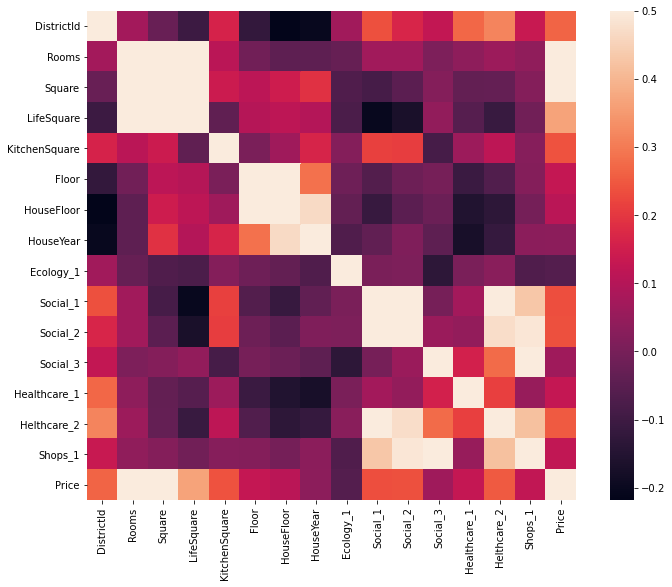

In [2306]:
corrmat = train.loc[:, (train.columns != 'A')&(train.columns != 'B')].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.5, square=True)

Видим наибольшую корреляцию между ценой и площадью квартиры, количеством комнат, а также жилой площадью. 

Среднее влияние на цену оказывают параметры: 
    район,  площадь кухни, социальные показатели местности, показатели местности, связанные с охраной здоровья, с наличием магазинов, торговых центров

Малое влияние на цену оказывают параметры:
    этаж, количество этажей в доме, год строительства
    
Экологические показатели местности практически не влияют на цену, поэтому при прогнозе их можно не учитывать.

Похожую картину мы видим на следующей диаграмме:

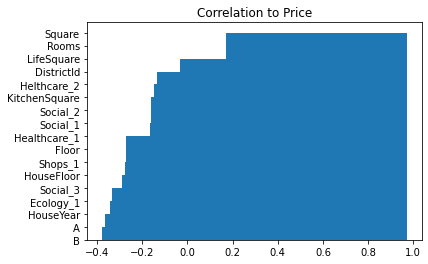

In [2307]:
corrmat = train.loc[:, train.columns != 'Price'].corrwith(
    train['Price']).abs().sort_values(ascending=True)[0:]
plt.bar(corrmat.values, corrmat.index)
plt.title('Correlation to Price')
plt.xticks()
plt.show()

In [2308]:
df = pd.read_csv('/Users/ekaterina/Downloads/project_task/train_prepared.csv')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,A,B,A.1,B.1,A.2,B.2
0,35.0,2.0,47.981560,29.442750,6.0,7,9.0,1969,0.089040,33.0,...,900.0,0,11.0,184966.94,0,1,0,1,0,1
1,41.0,3.0,65.683640,40.049540,8.0,7,9.0,1978,0.000070,46.0,...,240.0,1,16.0,300009.44,0,1,0,1,0,1
2,53.0,2.0,44.947952,29.197610,6.0,8,12.0,1968,0.049637,34.0,...,229.0,1,3.0,220925.90,0,1,0,1,0,1
3,58.0,2.0,53.352980,52.731510,9.0,8,17.0,1977,0.437885,23.0,...,1084.0,0,5.0,175616.23,0,1,0,1,0,1
4,99.0,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35.0,...,2078.0,2,4.0,150226.53,0,1,0,1,0,1


In [2309]:
df.shape

(9995, 22)

In [2310]:
df.dtypes

DistrictId       float64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Social_1         float64
Social_2           int64
Social_3         float64
Healthcare_1     float64
Helthcare_2        int64
Shops_1          float64
Price            float64
A                  int64
B                  int64
A.1                int64
B.1                int64
A.2                int64
B.2                int64
dtype: object

In [2311]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9995 entries, 0 to 9994
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     9995 non-null   float64
 1   Rooms          9995 non-null   float64
 2   Square         9995 non-null   float64
 3   LifeSquare     9995 non-null   float64
 4   KitchenSquare  9995 non-null   float64
 5   Floor          9995 non-null   int64  
 6   HouseFloor     9995 non-null   float64
 7   HouseYear      9995 non-null   int64  
 8   Ecology_1      9995 non-null   float64
 9   Social_1       9995 non-null   float64
 10  Social_2       9995 non-null   int64  
 11  Social_3       9995 non-null   float64
 12  Healthcare_1   9995 non-null   float64
 13  Helthcare_2    9995 non-null   int64  
 14  Shops_1        9995 non-null   float64
 15  Price          9995 non-null   float64
 16  A              9995 non-null   int64  
 17  B              9995 non-null   int64  
 18  A.1     

Отбор примеров

In [2312]:
df['Price'].value_counts().head(10)

298194.500    2
182938.080    2
238608.660    2
204576.420    2
311482.940    1
252808.390    1
156028.380    1
173399.750    1
236117.920    1
115037.086    1
Name: Price, dtype: int64

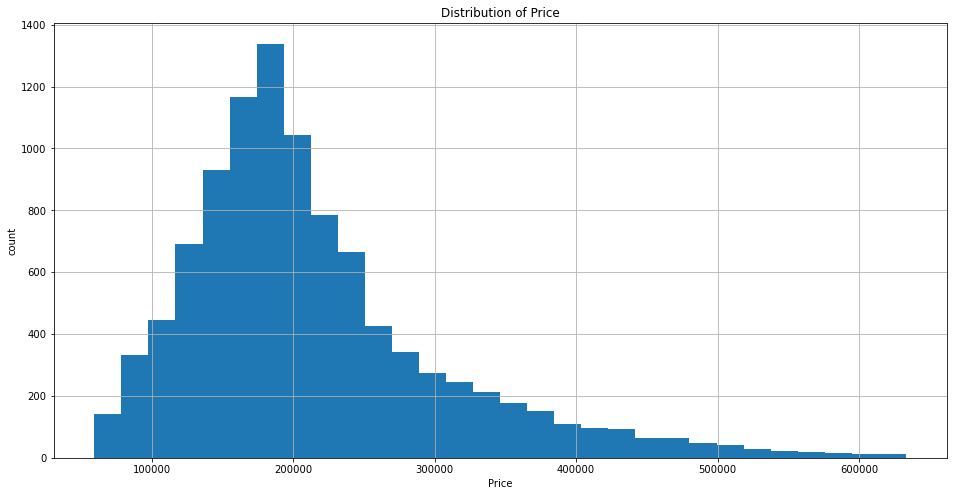

In [2313]:
plt.figure(figsize = (16, 8))

df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of Price')
plt.show()

In [2314]:
#df = df[df['Ecology_1'].isnull() |
                   # (df['Ecology_1'] < df['Ecology_1'].quantile(.99)) &
                    #(df['Ecology_1'] > df['Ecology_1'].quantile(.01))]

Отбор признаков

In [2315]:
df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'A',
 'B',
 'A.1',
 'B.1',
 'A.2',
 'B.2']

In [2316]:
feature_names = ['DistrictId', 'Rooms','Square','LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'A','B','A.1','B.1','A.2','B.2']

target_name = 'Price'

In [2317]:
df = df[feature_names + [target_name]]
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,A,B,A.1,B.1,A.2,B.2,Price
0,35.0,2.0,47.981560,29.442750,6.0,7,9.0,1969,0.089040,33.0,...,900.0,0,11.0,0,1,0,1,0,1,184966.94
1,41.0,3.0,65.683640,40.049540,8.0,7,9.0,1978,0.000070,46.0,...,240.0,1,16.0,0,1,0,1,0,1,300009.44
2,53.0,2.0,44.947952,29.197610,6.0,8,12.0,1968,0.049637,34.0,...,229.0,1,3.0,0,1,0,1,0,1,220925.90
3,58.0,2.0,53.352980,52.731510,9.0,8,17.0,1977,0.437885,23.0,...,1084.0,0,5.0,0,1,0,1,0,1,175616.23
4,99.0,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35.0,...,2078.0,2,4.0,0,1,0,1,0,1,150226.53


Стандартизация признаков

In [2318]:
df.mean()

DistrictId           50.587594
Rooms                 1.890345
Square               56.260702
LifeSquare           38.516717
KitchenSquare         6.281941
Floor                 8.527864
HouseFloor           13.539270
HouseYear          1984.866233
Ecology_1             0.118864
Social_1             25.193697
Social_2           5352.715858
Social_3              8.641321
Healthcare_1       1026.548174
Helthcare_2           1.319760
Shops_1               4.926563
A                     0.009705
B                     0.990295
A.1                   0.027514
B.1                   0.972486
A.2                   0.082541
B.2                   0.917459
Price            214111.711833
dtype: float64

In [2319]:
feature_names_for_stand = df[feature_names].select_dtypes(include='float64').columns.tolist()
feature_names_for_stand

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'HouseFloor',
 'Ecology_1',
 'Social_1',
 'Social_3',
 'Healthcare_1',
 'Shops_1']

In [2320]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [2321]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [2322]:
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,A,B,A.1,B.1,A.2,B.2,Price
0,-0.358656,0.134254,-0.426912,-0.479920,-0.058612,7,-0.785434,1969,-0.250559,0.454672,...,-0.169471,0,1.399877,0,1,0,1,0,1,184966.94
1,-0.220601,1.358587,0.485892,0.081071,0.357165,7,-0.785434,1978,-0.998018,1.211846,...,-1.053334,1,2.552336,0,1,0,1,0,1,300009.44
2,0.055507,0.134254,-0.583340,-0.492885,-0.058612,8,-0.266341,1968,-0.581590,0.512916,...,-1.068065,1,-0.444057,0,1,0,1,0,1,220925.90
3,0.170552,0.134254,-0.149936,0.751817,0.565053,8,0.598814,1977,2.680189,-0.127770,...,0.076939,0,0.016927,0,1,0,1,0,1,175616.23
4,1.113923,-1.090079,-0.856569,-0.779624,0.149276,11,-0.266341,1976,-0.894944,0.571160,...,1.408089,2,-0.213565,0,1,0,1,0,1,150226.53


In [2323]:
df.mean()

DistrictId       1.892989e-16
Rooms           -4.979397e-16
Square           9.684877e-17
LifeSquare      -9.862602e-17
KitchenSquare   -1.900431e-16
Floor            8.527864e+00
HouseFloor      -1.448455e-17
HouseYear        1.984866e+03
Ecology_1        9.180584e-17
Social_1        -1.486083e-17
Social_2         5.352716e+03
Social_3        -2.589391e-16
Healthcare_1     4.558190e-16
Helthcare_2      1.319760e+00
Shops_1          4.619727e-17
A                9.704852e-03
B                9.902951e-01
A.1              2.751376e-02
B.1              9.724862e-01
A.2              8.254127e-02
B.2              9.174587e-01
Price            2.141117e+05
dtype: float64

In [2324]:
df.std()

DistrictId           1.000050
Rooms                1.000050
Square               1.000050
LifeSquare           1.000050
KitchenSquare        1.000050
Floor                5.239558
HouseFloor           1.000050
HouseYear           18.413496
Ecology_1            1.000050
Social_1             1.000050
Social_2          4006.137703
Social_3             1.000050
Healthcare_1         1.000050
Helthcare_2          1.493701
Shops_1              1.000050
A                    0.098039
B                    0.098039
A.1                  0.163583
B.1                  0.163583
A.2                  0.275201
B.2                  0.275201
Price            92828.518754
dtype: float64

Понизим размерность данных

In [2325]:
from sklearn.decomposition import PCA

In [2326]:
pca = PCA(n_components=1)

получим матрицу объект-признак

In [2327]:
result_ = pca.fit_transform(df)

print(result_)

[[-29116.14784319]
 [ 85944.30239757]
 [  6838.65784638]
 ...
 [-55013.72287495]
 [-32517.78514868]
 [  4596.39847263]]


Кроме того, использование модели из `sklearn` позволяет нам также посмотреть, какую долю объяснённой дисперсии содержит данная главная компонента:


In [2328]:
pca.explained_variance_ratio_

array([0.99824708])

Мы видим, что это значение близко к 1. Это означает, что мы потеряли менее 1 процента информации. В общем случае, потеря информации до 10 процентов считается не очень большой.

Добавим дополнительный параметр:

In [2330]:
#medium_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                      # .rename(columns={'Price':'MedPriceByDistrict'})

#medium_price_by_district.head()

In [2331]:
#df = df.merge(medium_price_by_district, on=['DistrictId', 'Rooms'], how='left')
#df.head()

Дополнительный параметр не улучшил качество модели, пока не используем

Обучающий датасет готов

Сохраним обработанные данные в файл

In [2332]:
train.to_csv('/Users/ekaterina/Downloads/project_task/train_to_learn.csv', index=False, encoding='utf-8')

Разобьем данные на тренировочный и тестовый датасеты:

In [2333]:
X = df[feature_names]
y = df[target_name]

In [2334]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=100)

## Построение базовых моделей и выбор лучшей

Загрузим метрики

MAE - Mean Absolute Error 

MSE - Mean Squared Error

RMSE - Root Mean Squared Error

R2 - coefficient of determination

In [2335]:
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from math import sqrt

In [2336]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(sqrt(mse(true_values, pred_values)), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()
    return None

In [2337]:
def evaluate_preds_sec(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(train_true_values, train_pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(train_true_values, train_pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(sqrt(mse(train_true_values, train_pred_values)), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(test_true_values, test_pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(test_true_values, test_pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(sqrt(mse(test_true_values, test_pred_values)), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

## Построим модель линейной регрессии:

In [2338]:
lr_model = LinearRegression()

In [2339]:
lr_model.fit(X_train, y_train)

LinearRegression()

Train R2:	0.546
MAE:	43745.173
MSE:	3922218514.597
RMSE:	62627.618
Test R2:	0.748
MAE:	27418.927
MSE:	2159396399.344
RMSE:	46469.306


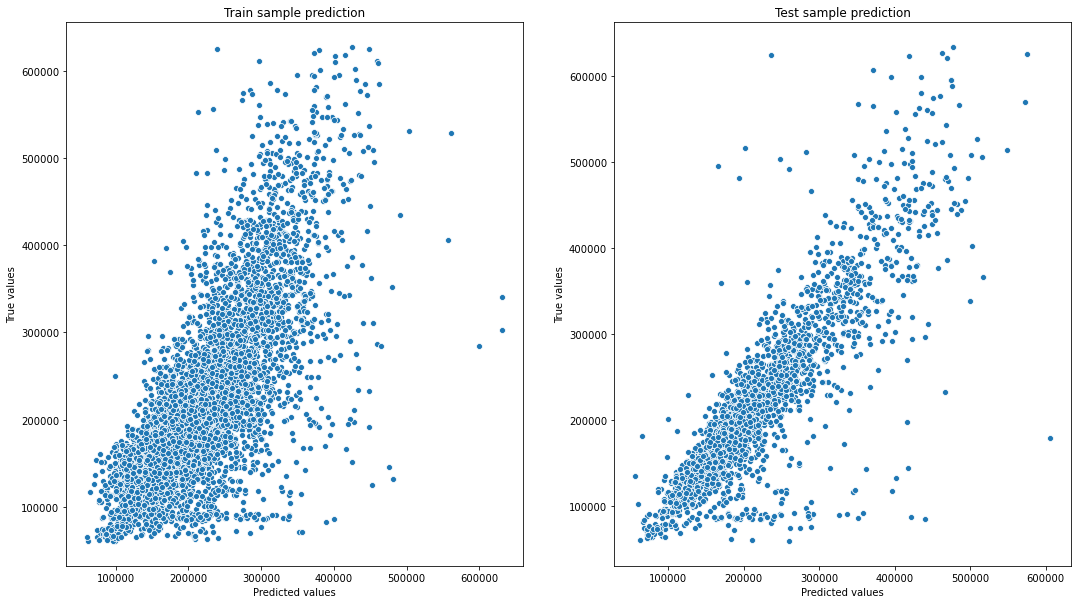

In [2340]:
y_train_preds = lr_model.predict(X_train)
evaluate_preds_sec(y_train, y_train_preds, y_test, y_test_preds)

R2:	0.508
MAE:	43935.626
MSE:	4210356603.234
RMSE:	64887.261


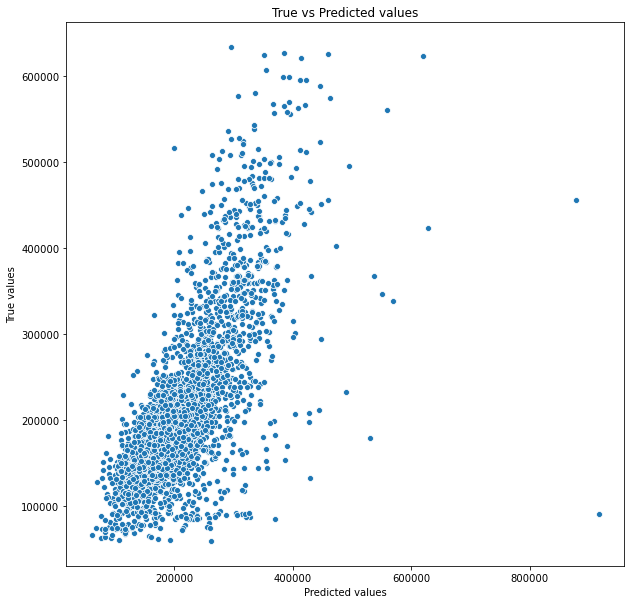

In [2341]:
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

визуализируем то, какой вклад вносит каждый из коэффициентов:

In [2342]:
lr_model.intercept_

839042.6295631437

In [2343]:
lr_model.coef_

array([ 1.77862293e+04,  1.68700030e+04,  5.54494809e+04, -1.46617607e+04,
        4.78204312e+03,  1.45341897e+03,  9.98795306e+03, -3.44046356e+02,
       -4.46921496e+03,  3.83807848e+03,  3.31639026e+00,  5.42274165e+03,
        4.67137469e+03,  7.20915267e+03, -1.03554066e+04, -1.77018632e+04,
        1.77018632e+04,  8.57576919e+03, -8.57576919e+03, -1.17081856e+04,
        1.17081856e+04])

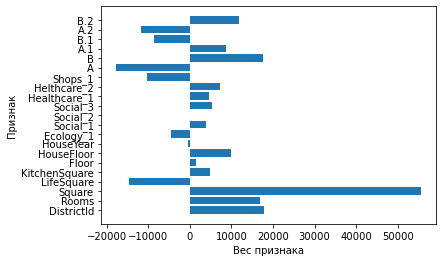

In [2344]:
plt.barh(feature_names, lr_model.coef_.flatten())
plt.xlabel("Вес признака")
plt.ylabel("Признак")
plt.show()

## Random Forest Regressor

In [2345]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

Train R2:	0.961
MAE:	10778.22
MSE:	335223593.239
RMSE:	18309.112
Test R2:	0.508
MAE:	43935.626
MSE:	4210356603.234
RMSE:	64887.261


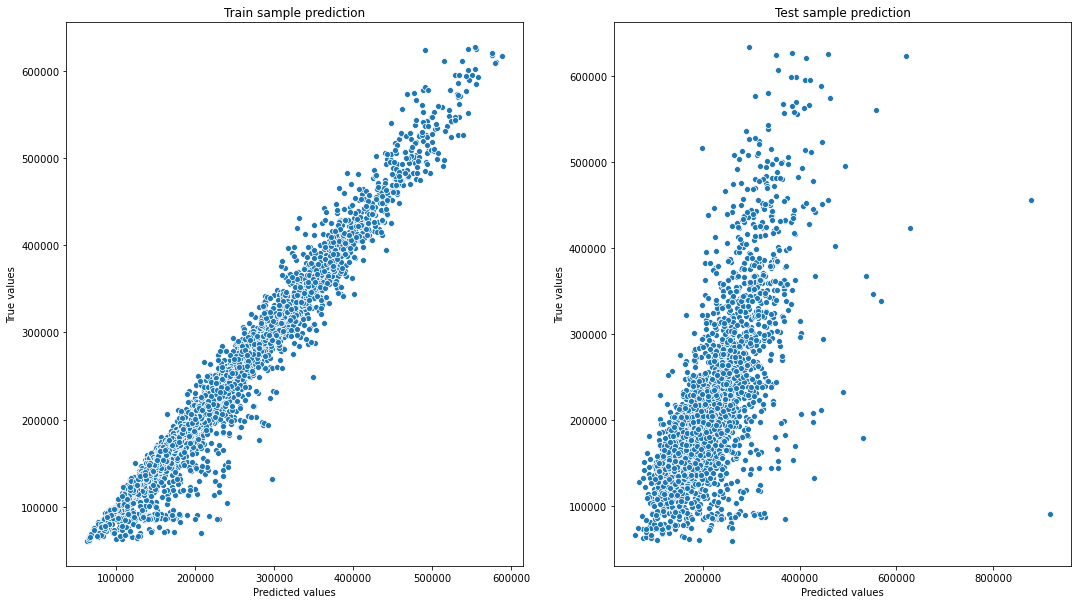

In [2346]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds_sec(y_train, y_train_preds, y_test, y_test_preds)

R2:	0.736
MAE:	28413.623
MSE:	2256562957.253
RMSE:	47503.294


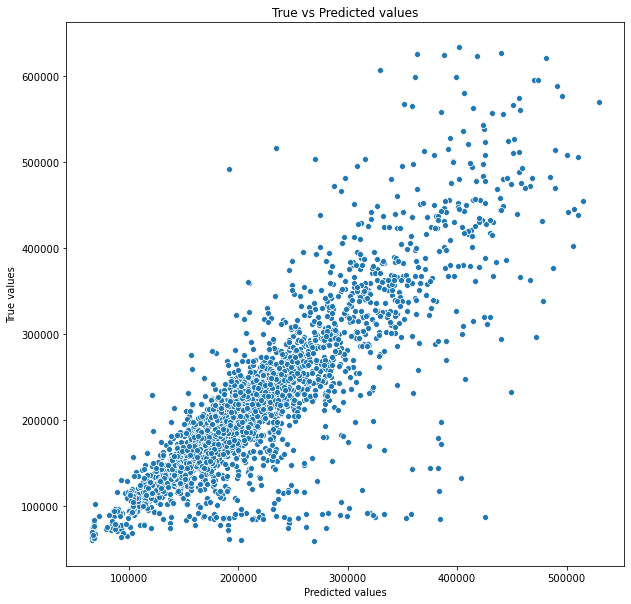

In [2347]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

**Отложенная выборка**

Train R2:	0.961
MAE:	10778.22
MSE:	335223593.239
RMSE:	18309.112
Test R2:	0.736
MAE:	28413.623
MSE:	2256562957.253
RMSE:	47503.294


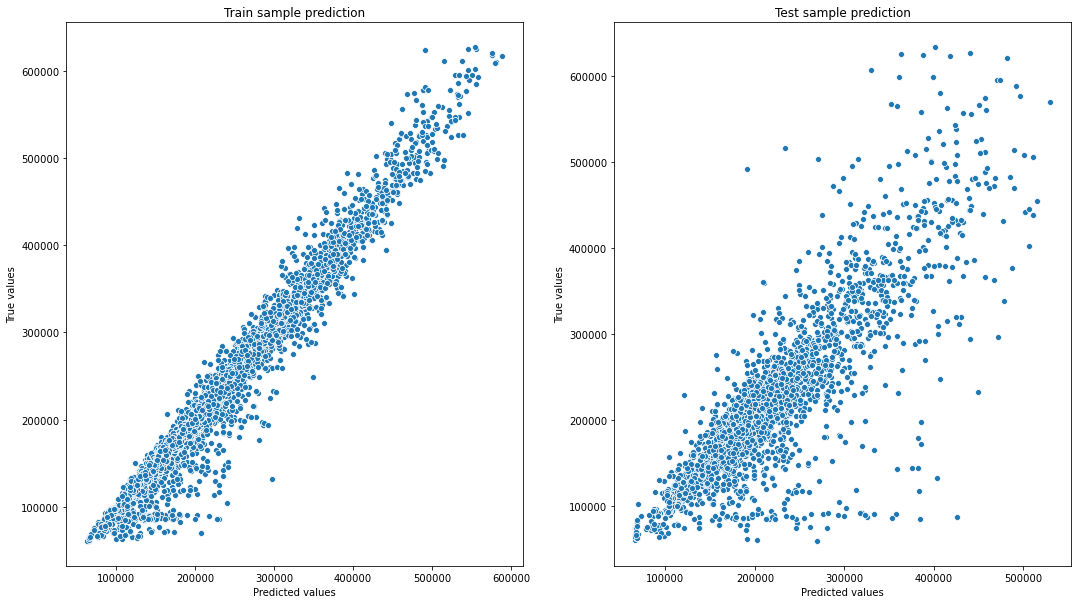

In [2348]:
y_train_preds = rf_model.predict(X_train.fillna(-9999))
y_test_preds = rf_model.predict(X_test)

evaluate_preds_sec(y_train, y_train_preds, y_test, y_test_preds)

**Перекрёстная проверка (кросс-валидация)**

In [2349]:
cv_score = cross_val_score(rf_model, X.fillna(-9999), y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.72541336, 0.726989  , 0.73892138, 0.74701504, 0.70945966])

In [2350]:
cv_score.mean(), cv_score.std()

(0.7295596879637787, 0.012807358700590802)

In [2351]:

cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7167523292631879, 0.7423670466643695)

**Важность признаков**

In [2352]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

In [2353]:
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.386158
10,Social_2,0.169511
1,Rooms,0.076152
11,Social_3,0.056550
0,DistrictId,0.046256
8,Ecology_1,0.040955
3,LifeSquare,0.036661
7,HouseYear,0.034681
5,Floor,0.029991
6,HouseFloor,0.029585


## Gradient Boosting Regressor

In [2354]:
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

GradientBoostingRegressor()

Train R2:	0.76
MAE:	29051.352
MSE:	2075177460.719
RMSE:	45554.116
Test R2:	0.736
MAE:	28413.623
MSE:	2256562957.253
RMSE:	47503.294


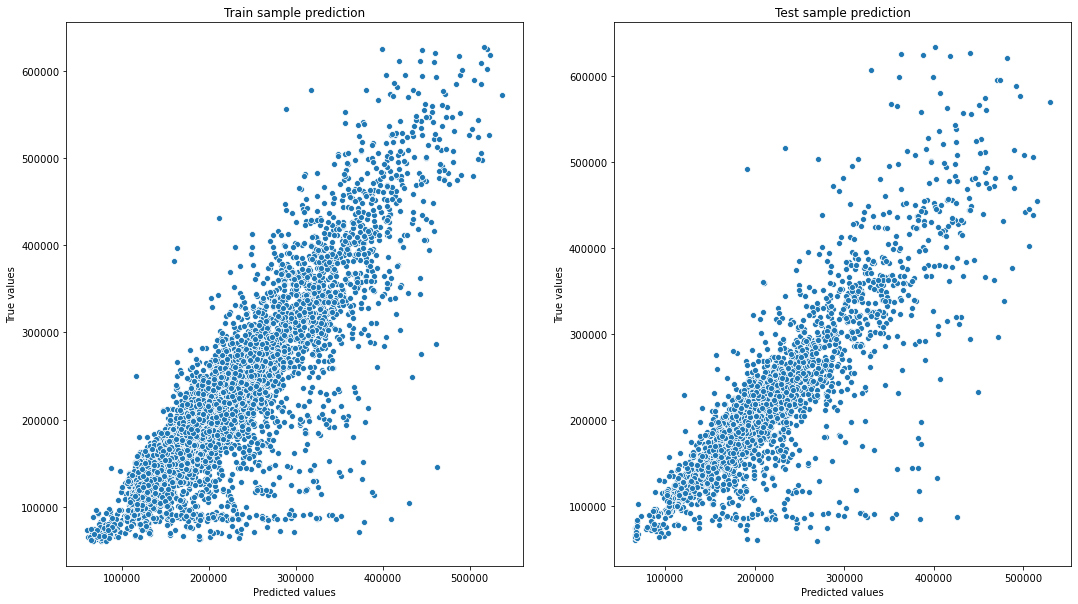

In [2355]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds_sec(y_train, y_train_preds, y_test, y_test_preds)

R2:	0.727
MAE:	30045.903
MSE:	2339005151.288
RMSE:	48363.262


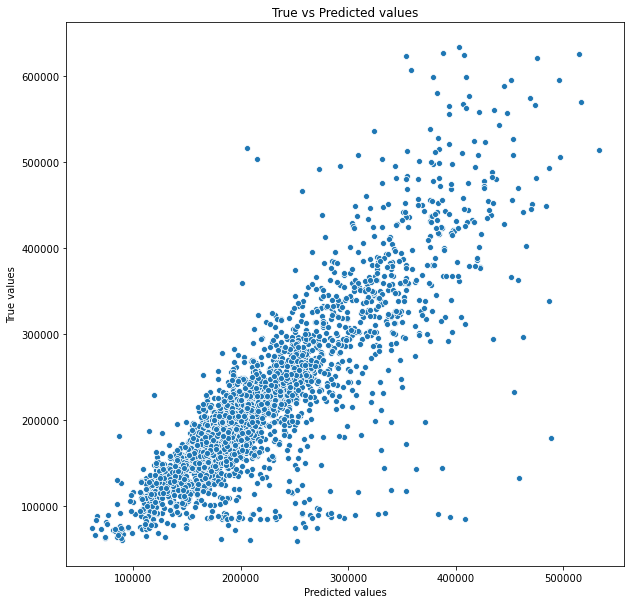

In [2356]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

## Настройка и оценка финальной модели

Подбор гиперпараметров

In [2357]:
0.6*X_train.shape[1]

12.6

In [2358]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model

GradientBoostingRegressor(random_state=42)

In [2359]:
rf_model = RandomForestRegressor(random_state=42)
rf_model

RandomForestRegressor(random_state=42)

параметры модели:

n_estimators - число деревьев в ансамбле

max_features - максимальное число признаков, которое может быть использовано при построении каждого дерева

max_depth - максимальная глубина дерева

Зададим сетку параметров, по которой мы хотели бы провести поиск:

parameters = { 'n_estimators': [150, 200, 250], 'max_features': np.arange(5, 9), 'max_depth': np.arange(5, 10), }

In [2360]:
params = {'n_estimators':[150, 200, 300, 400], 
          'max_depth':[4, 7, 10, 12]}

gs = GridSearchCV(gb_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=42, shuffle=True), n_jobs=-1)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [4, 7, 10, 12],
                         'n_estimators': [150, 200, 300, 400]},
             scoring='r2')

`GridSearchCV` - это классификатор, который строится на основе модели `estimator`, пробегая все комбинации значений из `param_grid`. Для каждой комбинации параметров по кросс-валидации на указанном количестве _фолдов_ считается метрика, указанная в `scoring`. Наконец, выбирается та комбинация параметров, при которой выбранная метрика оказалась максимальной, и дальше для предсказания используется именно этот набор параметров.

In [2361]:
gsrf = GridSearchCV(rf_model, params, scoring='r2', cv=KFold(n_splits=3, random_state=42, shuffle=True), n_jobs=-1)
gsrf.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [4, 7, 10, 12],
                         'n_estimators': [150, 200, 300, 400]},
             scoring='r2')

In [2362]:
gs.best_params_

{'max_depth': 4, 'n_estimators': 300}

In [2363]:
gsrf.best_params_

{'max_depth': 12, 'n_estimators': 400}

In [2364]:
gs.best_score_

0.7441140195972652

In [2365]:
gsrf.best_score_

0.7260076935409066

## Обучение и оценка модели

In [2366]:
final_model = GradientBoostingRegressor(n_estimators=300, max_depth=4, random_state=42)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=4, n_estimators=300, random_state=42)

Train R2:	0.88
MAE:	20936.339
MSE:	1036562127.511
RMSE:	32195.685
Test R2:	0.727
MAE:	30045.903
MSE:	2339005151.288
RMSE:	48363.262


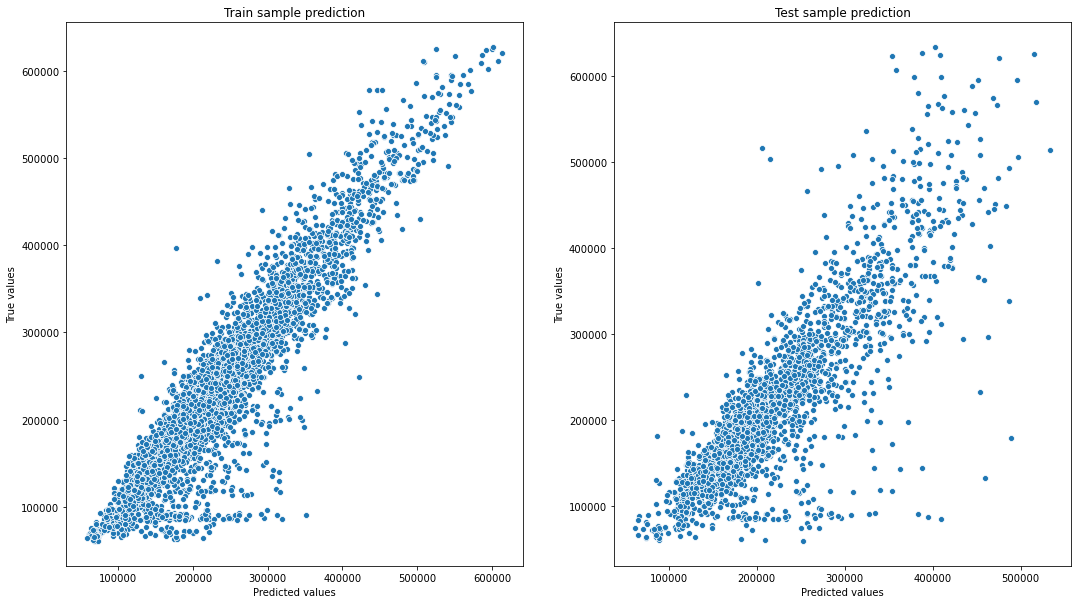

In [2367]:
y_train_preds = final_model.predict(X_train)
evaluate_preds_sec(y_train, y_train_preds, y_test, y_test_preds)

R2:	0.748
MAE:	27418.927
MSE:	2159396399.344
RMSE:	46469.306


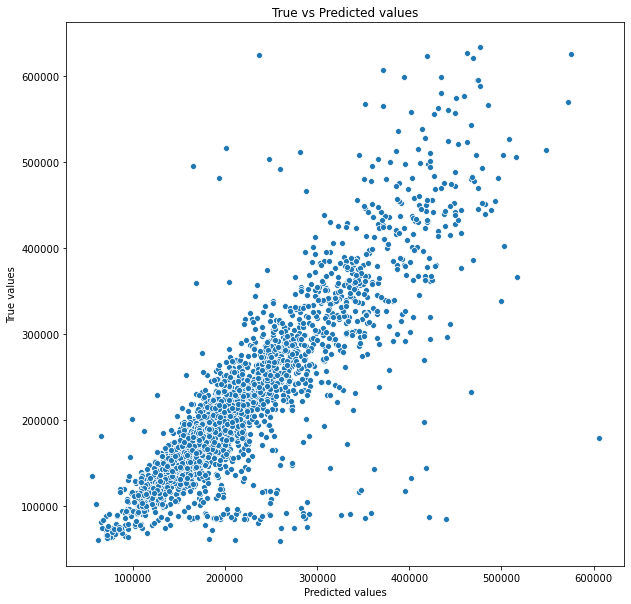

In [2368]:
y_test_preds = final_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

Важность признаков

In [2369]:
feature_importances = pd.DataFrame(zip(X_train.columns, final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.433326
10,Social_2,0.165634
11,Social_3,0.079147
0,DistrictId,0.057387
1,Rooms,0.055984
8,Ecology_1,0.037923
7,HouseYear,0.027656
12,Healthcare_1,0.026021
6,HouseFloor,0.024246
9,Social_1,0.021587


Сохранение модели

**Scaler**

In [2370]:
df.to_csv('/Users/ekaterina/Downloads/project_task/scaler.pkl')

In [2371]:
with open('/Users/ekaterina/Downloads/project_task/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [2372]:
with open('/Users/ekaterina/Downloads/project_task/scaler.pkl', "rb") as file:
    new_scaler = pickle.load(file)

**Model**

In [2373]:
df.to_csv('/Users/ekaterina/Downloads/project_task/model.pkl')

In [2374]:
with open('/Users/ekaterina/Downloads/project_task/model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

Результат:

In [2405]:
test = pd.read_csv('/Users/ekaterina/Downloads/project_task/test.csv')

Обработаем данные тестового датасета:

 Исключим признак id



In [2406]:
test = test[test.columns[1:]]

Преобразуем категориальные признаки в бинарные:

    -получим доп.таблицы
    
    -присоединим их к датасету
    
    -удалим столбцы с нечисловыми значениями

In [2407]:
test['Shops_2'].unique()

array(['B', 'A'], dtype=object)

In [2408]:
test['Ecology_2'].unique()

array(['B', 'A'], dtype=object)

In [2409]:
pd.get_dummies(test['Ecology_2'])[:2]
pd.get_dummies(test['Ecology_3'])[:2]
pd.get_dummies(test['Shops_2'])[:2]

,A,B
0,0,1
1,0,1


In [2410]:
test = pd.concat([test, pd.get_dummies(test['Ecology_2'])], axis = 1)
test = pd.concat([test, pd.get_dummies(test['Ecology_3'])], axis = 1)
test = pd.concat([test, pd.get_dummies(test['Shops_2'])], axis = 1)

In [2411]:
test = test.drop(['Ecology_2'], axis = 1)
test = test.drop(['Ecology_3'], axis = 1)
test = test.drop(['Shops_2'], axis = 1)

In [2412]:
test.loc[(test['Healthcare_1'] == 0), 'Healthcare_1'] = test['Healthcare_1'].median()

In [2413]:
test.loc[(test['Healthcare_1'].isnull(), 'Healthcare_1')] = test['Healthcare_1'].median()

In [2414]:
test['Healthcare_1']

0        900.0
1        900.0
2       4702.0
3        900.0
4        900.0
         ...  
4995     900.0
4996     900.0
4997     900.0
4998     900.0
4999    1046.0
Name: Healthcare_1, Length: 5000, dtype: float64

LifeSquare



In [2415]:
test[test['LifeSquare'].isnull()]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,A,B,A,B,A,B
1,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,6,...,3,900.0,0,2,0,1,0,1,0,1
5,53,1.0,40.675627,NaN,1.0,21,21.0,1977,0.049637,34,...,0,229.0,1,3,0,1,0,1,0,1
11,6,3.0,84.625350,NaN,1.0,6,17.0,1977,0.243205,5,...,0,540.0,0,0,0,1,0,1,0,1
14,27,1.0,37.555197,NaN,1.0,5,1.0,1977,0.211401,9,...,0,900.0,0,1,0,1,0,1,0,1
21,1,1.0,44.878767,NaN,1.0,1,9.0,1977,0.007122,1,...,0,900.0,0,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,95,1.0,45.542940,NaN,0.0,6,0.0,1977,0.000699,14,...,24,4129.0,0,3,0,1,0,1,0,1
4985,1,1.0,46.597283,NaN,1.0,17,24.0,1977,0.007122,1,...,0,900.0,0,1,0,1,0,1,0,1
4987,53,3.0,80.102103,NaN,1.0,13,22.0,1977,0.049637,34,...,0,229.0,1,3,0,1,0,1,0,1
4998,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,2,...,1,900.0,0,0,0,1,0,1,1,0


In [2416]:
test.loc[(test['LifeSquare'].isnull(), 'LifeSquare')] = test['Square']-10

In [2417]:
test.loc[(test['LifeSquare'] - test['Square'] >= 3)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,A,B,A,B,A,B
43,1,1.0,37.484057,40.593036,0.0,4,17.0,1977,0.007122,1,...,0,900.0,0,1,0,1,0,1,0,1
337,23,2.0,54.350505,57.376990,1.0,4,3.0,1977,0.005767,1,...,0,900.0,0,0,0,1,0,1,0,1
410,94,2.0,48.713443,303.071094,6.0,5,12.0,1974,0.521867,25,...,0,900.0,0,0,0,1,0,1,0,1
919,27,3.0,45.411358,49.883368,0.0,18,25.0,1977,0.072158,2,...,1,900.0,0,0,0,1,0,1,1,0
961,34,3.0,82.865214,86.903526,10.0,26,25.0,2016,0.069753,53,...,4,900.0,1,11,0,1,0,1,0,1
1138,1,2.0,62.981007,66.227189,0.0,13,24.0,1977,0.007122,1,...,0,900.0,0,1,0,1,0,1,0,1
1601,1,2.0,66.450403,69.495211,0.0,4,24.0,1977,0.007122,1,...,0,900.0,0,1,0,1,0,1,0,1
1672,1,1.0,53.622428,57.760545,1.0,10,15.0,1977,0.007122,1,...,0,900.0,0,1,0,1,0,1,0,1
1804,54,2.0,74.735135,78.340613,1.0,7,1.0,2014,0.006076,30,...,0,645.0,6,6,0,1,0,1,0,1
1835,27,1.0,37.142672,40.830384,1.0,3,15.0,2014,0.211401,9,...,0,900.0,0,1,0,1,0,1,0,1


In [2418]:
test.loc[(test['Square'] < test['LifeSquare'], 'LifeSquare')] = test['Square']-10

In [2419]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     5000 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Social_1       5000 non-null   int64  
 10  Social_2       5000 non-null   int64  
 11  Social_3       5000 non-null   int64  
 12  Healthcare_1   5000 non-null   float64
 13  Helthcare_2    5000 non-null   int64  
 14  Shops_1        5000 non-null   int64  
 15  A              5000 non-null   uint8  
 16  B              5000 non-null   uint8  
 17  A              5000 non-null   uint8  
 18  B       

## Предскажем цены на квартиры:

In [2421]:
y_pred = final_model.predict(test)
y_pred 

array([476498.30928143, 213623.95748961, 344709.06860306, ...,
       375179.25868942, 298210.63049002, 376793.88445205])

Для подсчёта правильных ответов будем использовать метрику _accuracy_ (_точность_). Она равна отношению числа объектов, на которых целевой класс был угадан верно, к общему числу объектов.

In [2427]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train[1:5001], y_pred[0:5000])

ValueError: continuous is not supported

Метрики оценки качества моделей регрессии

Чтобы оценить то, насколько отличаются реальные значения от предсказанных, создадим отдельный столбец с их разностями:

check_test["error"] = check_test["y_pred"] - check_test["y_test"]
check_test.head()

Одной из основных метрик для оценки качества моделей регрессии является средняя квадратическая ошибка или mean squared error_, сокращённо _mse. Она вычисляется как среднее от квадратов ошибок на каждом из объектов:
mse1 = (check_test["error"] ** 2).mean()
mse1
Эта метрика есть в готовом виде в библиотеке sklearn:
from sklearn.metrics import mean_squared_error
mean_squared_error(check_test["y_pred"], check_test["y_test"])

Также применяется средняя абсолютная ошибка. Она представляет из себя среднее не от квадратов ошибок, а от их модулей:
(np.abs(check_test["error"])).mean()
Данная метрика также доступна в готовом виде:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(check_test["y_pred"], check_test["y_test"])
Эта метрика отличается от mse тем, что не так сильно реагирует на выбросы в данных, например, на те ситуации, в которых у некоторых объектов недвижимости сильно завышена или сильно занижена цена.

Выводы:

## Выгрузка данных:

test[['Id', 'Price']].to_csv('/Users/ekaterina/Downloads/project_task/Macerszmidt_predictions.csv', index=None)

*Пример переноса признака на test*

test_df['DistrictId'] = test_df['DistrictId'].astype(str)

test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').info()

## Алгоритм t-SNE

Алгоритм _t-SNE_ (_t-distributed Stochastic Neighbor Embedding_ или _Стохастическое вложение соседей с t-распределением_) позволяет понижать размерность данных до двух или трёх измерений, что позволяет визуализировать данные на двумерных и трёхмерных графиках. Изучая графики, можно, например, понять, на сколько кластеров адекватно разбивать данные, а также оценить уже выполненное разбиение на кластеры.

Итак, перейдём к использованию t-SNE. 
Зададим параметр `n_components=2`, чтобы получить данные с двумя признаками. 
Параметр `learning_rate` влияет на то, как плотно будут располагаться точки. 
Рекомендуется задавать его в диапазоне от 10 до 1000.


#scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [ ]:
tsne = TSNE(n_components=2, learning_rate=150, random_state=100)

In [ ]:
X_train_tsne = tsne.fit_transform(df[feature_names_for_stand])

In [ ]:
print('До:\t{}'.format(df[feature_names_for_stand].shape))
print('После:\t{}'.format(X_train_tsne.shape))

Мы видим, что число признаков уменьшилось с 10 до 2. Теперь можно визуализировать наши данные на плоскости.

In [ ]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])

plt.show()

По графику видно, что данные можно разбить как минимум на 2 кластера. Попробуем сделать это с помощью уже известного нам метода K-means и ещё раз построим график, но уже с полученными метками кластеров.



In [ ]:
kmeans = KMeans(n_clusters=2)

labels_train = kmeans.fit_predict(df[feature_names_for_stand])


In [ ]:

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labels_train)

plt.show()

Как мы видим, при кластеризации мы получили практически такое же разбиение, как то, которое можно было наблюдать в результате t-SNE.

Для тестовой выборки получить аналогичный график нам не удастся, поскольку у алгоритма t-SNE нет метода `.transform`. Однако, с помощью алгоритма K-means мы можем получить метки кластеров для тестовой выборки с помощью метода `.predict` и использовать их:

Давайте посмотрим на объекты из разных кластеров, чтобы попытаться понять, почему алгоритм t-SNE выделил две группы. Например, посмотрим на среднюю цену недвижимости во всей выборке и в отдельных кластерах.



In [ ]:
labels_test = kmeans.predict(stand_features)

In [ ]:
y_train.mean()

In [ ]:
#y_train[labels_train == 0].mean()

In [ ]:
#y_train[labels_train == 1].mean()

In [ ]:
#plt.hist(y_train[labels_train == 0], bins=20, density=True, alpha=0.5)
#plt.hist(y_train[labels_train == 1], bins=20, density=True, alpha=0.5)

plt.legend(['Кластер 0', 'Кластер 1'])
plt.xlabel('Цена')
plt.show()


Гистограмма также отражает замеченную закономерность. Заметим, что мы не использовали цену на недвижимость ни при использовании t-SNE, ни при использовании K-means.

Посмотрим теперь на распределение отдельных признаков внутри кластеров. Например, `'RM'` - количество комнат.

print('Кластер 0: {}'.format(X_train.loc[labels_train == 0, 'RM'].mean()))
print('Кластер 1: {}'.format(X_train.loc[labels_train == 1, 'RM'].mean()))

Значения не сильно отличаются. Не похоже, что этот признак внёс какой-то вклад в разбиение. Рассмотрим другой признак - `'CRIM'`. Он отражает криминальность места, в котором расположена недвижимость (количество преступлений на душу населения).

print('Кластер 0: {}'.format(X_train.loc[labels_train == 0, 'CRIM'].mean()))
print('Кластер 1: {}'.format(X_train.loc[labels_train == 1, 'CRIM'].mean()))

Видно, что данное значение сильно выше для второго кластера. Рассмотрим гистограммы распределений значений этого признака по кластерам.

plt.hist(X_train.loc[labels_train == 0, 'CRIM'], bins=20, density=True, alpha=0.5)
plt.hist(X_train.loc[labels_train == 1, 'CRIM'], bins=20, density=True, alpha=0.5)

plt.xlim(0, 12)
plt.legend(['Кластер 0', 'Кластер 1'])
plt.xlabel('CRIM')

plt.show()

В кластере 0 максимальная плотность этого признака расположена возле 0. Для кластера 1 значения этого признака более разнообразны.

Ещё один интересный признак - концентрация оксида азота в воздухе (`'NOX'`). Построим гистограммы распределения этого признака.

plt.hist(X_train.loc[labels_train == 0, 'NOX'], bins=20, density=True, alpha=0.5)
plt.hist(X_train.loc[labels_train == 1, 'NOX'], bins=20, density=True, alpha=0.5)

plt.xlim(0, 1.2)
plt.legend(['Кластер 0', 'Кластер 1'])
plt.xlabel('NOX')

plt.show()

Вновь кластер 1 в этом плане отличается в худшую сторону. 

Итак, как нам теперь использовать полученную информацию? Мы можем, например, попробовать построить отдельную модель для каждого кластера. Сначала построим модель на всех данных. Для оценки качества модели будем использовать `r2_score`.

lr.fit(X_train_scaled, y_train)

y_test_pred = lr.predict(X_test_scaled)

r2_score(y_test, y_test_pred)

Итак, мы получили базовое значение. Построим теперь разные модели для объектов разных кластеров и посмотрим, какое качество мы сможем получить на них.

Модель для кластера 0:

lr.fit(X_train_scaled.loc[labels_train == 0], y_train[labels_train == 0])

y_test_pred_0 = lr.predict(X_test_scaled.loc[labels_test == 0])

r2_score(y_test[labels_test == 0], y_test_pred_0)

Модель для кластера 1:

lr.fit(X_train_scaled.loc[labels_train == 1], y_train[labels_train == 1])

y_test_pred_1 = lr.predict(X_test_scaled.loc[labels_test == 1])

r2_score(y_test[labels_test == 1], y_test_pred_1)

Для кластера 0 мы получили большее значение `r2_score`, однако, сравнивать эти модели пока рано, потому что данное значение получено не на всех данных. Соберём теперь данные по кусочкам и проверим значение `r2_score`.


y_test_all = np.hstack([y_test[labels_test == 0], y_test[labels_test == 1]])
y_test_pred_all = np.hstack([y_test_pred_0, y_test_pred_1])

r2_score(y_test_all, y_test_pred_all)